In [1]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *

import matplotlib.pyplot as plt

In [2]:
def plot_gmm(x, dist, label=''):
    y = dist.gm.pdf(x)
    plt.plot(x, y, label=label)

def plot_pdf(x, pdf, label=''):
    y = pdf(x)
    plt.plot(x, y, label=label)

In [3]:
compiledFile=compile2SOGA_text('x = gm([0.1, 0.1, 0.2, 0.2, 0.4], [0.75, 1.25, 2., 3., 5.], [0.15, 0.1, 0.15, 0.1, 0.15]);')
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

#params_dict = {'pi1': torch.tensor(0.1, requires_grad=True),
#                'pi2': torch.tensor(0.8, requires_grad=True),}

params_dict = {}

output_dist = start_SOGA(cfg, params_dict, pruning='classic')
output_dist

Dist<['x'],pi: tensor([[0.1000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.4000]])
mu: tensor([[0.7500],
        [1.2500],
        [2.0000],
        [3.0000],
        [5.0000]])
sigma: tensor([[[0.0225]],

        [[0.0100]],

        [[0.0225]],

        [[0.0100]],

        [[0.0225]]])>

In [4]:
compiledFile=compile2SOGA_text('x = gm([0.1, 0.1, 0.2, 0.2, 0.4], [0.75, 1.25, 2., 3., 5.], [0.1, 0.1, 0.1, 0.1, 0.1]); prune(3);')
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

#params_dict = {'pi1': torch.tensor(0.1, requires_grad=True),
#                'pi2': torch.tensor(0.8, requires_grad=True),}

params_dict = {}

output_dist_classic = start_SOGA(cfg, params_dict, pruning='classic')
output_dist_classic

Dist<['x'],pi: tensor([[0.4000],
        [0.2000],
        [0.4000]])
mu: tensor([[5.0000],
        [1.0000],
        [2.5000]])
sigma: tensor([[[0.0100]],

        [[0.0725]],

        [[0.2600]]])>

In [5]:
compiledFile=compile2SOGA_text('x = gm([0.1, 0.1, 0.2, 0.2, 0.4], [0.75, 1.25, 2., 3., 5.], [0.1, 0.1, 0.1, 0.1, 0.1]); prune(3);')

cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

#params_dict = {'pi1': torch.tensor(0.1, requires_grad=True),
#                'pi2': torch.tensor(0.8, requires_grad=True),}

params_dict = {}

output_dist_ranking = start_SOGA(cfg, params_dict, pruning='ranking')
output_dist_ranking

Dist<['x'],pi: tensor([[0.5000],
        [0.2500],
        [0.2500]])
mu: tensor([[5.],
        [2.],
        [3.]])
sigma: tensor([[[0.0100]],

        [[0.0100]],

        [[0.0100]]])>

In [6]:
compiledFile=compile2SOGA_text('x = gm([0.1, 0.1, 0.2, 0.2, 0.4], [0.75, 1.25, 2., 3., 5.], [0.1, 0.1, 0.1, 0.1, 0.1]); prune(3);')

cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

#params_dict = {'pi1': torch.tensor(0.1, requires_grad=True),
#                'pi2': torch.tensor(0.8, requires_grad=True),}

params_dict = {}

output_dist_kmeans = start_SOGA(cfg, params_dict, pruning='kmeans')
output_dist_kmeans

Dist<['x'],pi: tensor([[0.4000],
        [0.4000],
        [0.2000]])
mu: tensor([[5.0000],
        [2.5000],
        [1.0000]])
sigma: tensor([[[0.0100]],

        [[0.2600]],

        [[0.0725]]])>

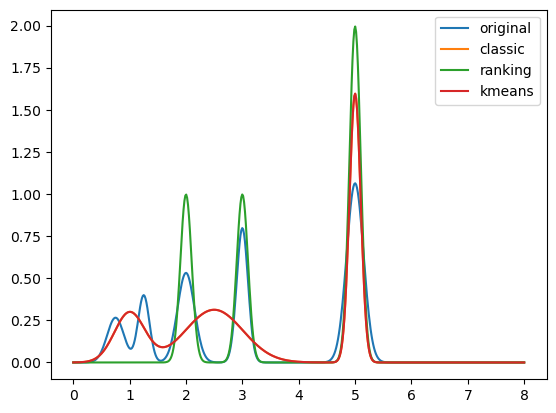

In [7]:
x = torch.linspace(0,8,500).reshape(-1,1)

plot_gmm(x, output_dist, label='original')
plot_gmm(x, output_dist_classic, label='classic')
plot_gmm(x, output_dist_ranking, label='ranking')
plot_gmm(x, output_dist_kmeans, label='kmeans')
plt.legend()

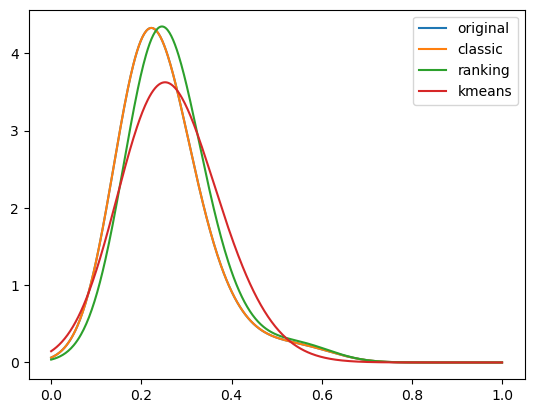

In [8]:
from time import time

# To test performances we use the Bernoulli program

bernoulli = """
data obs = [0, 1, 0, 0, 0, 0, 0, 0, 0, 1];

theta = uniform([0,1], 2);
 
for i in range(10) {
    if uniform([0,1], 2) - theta < 0 {
        y = 1.;
    } else { 
        y = 0.; 
    } end if;
    observe(y == obs[i]);
} end for;
"""

# computes the output for the original program

compiledFile=compile2SOGA_text(bernoulli)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
params_dict = {}

start = time()
output_dist = start_SOGA(cfg, params_dict)
end = time()
times = {'original': end-start}

# pruning with classic method

bernoulli_prune = """
data obs = [0, 1, 0, 0, 0, 0, 0, 0, 0, 1];

theta = uniform([0,1], 2);
 
for i in range(10) {
    if uniform([0,1], 2) - theta < 0 {
        y = 1.;
    } else { 
        y = 0.; 
    } end if;
    observe(y == obs[i]);
    prune(100);
} end for;
"""

compiledFile=compile2SOGA_text(bernoulli_prune)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
params_dict = {}

start = time()
output_dist_classic = start_SOGA(cfg, params_dict, pruning='classic')
end = time()
times['classic'] = end-start

start = time()
output_dist_ranking = start_SOGA(cfg, params_dict, pruning='ranking')
end = time()
times['ranking'] = end-start

start = time()
output_dist_kmeans = start_SOGA(cfg, params_dict, pruning='kmeans')
end = time()
times['kmeans'] = end-start

x = torch.linspace(0,1,500).reshape(-1,1)
plot_pdf(x, lambda x : output_dist.gm.marg_pdf(x, 0), label='original')
plot_pdf(x, lambda x : output_dist_classic.gm.marg_pdf(x, 0), label='classic')
plot_pdf(x, lambda x : output_dist_ranking.gm.marg_pdf(x, 0), label='ranking')
plot_pdf(x, lambda x : output_dist_kmeans.gm.marg_pdf(x, 0), label='kmeans')
plt.legend()

In [9]:
times

{'original': 0.1570878028869629,
 'classic': 0.8462302684783936,
 'ranking': 0.1263720989227295,
 'kmeans': 0.449631929397583}